# End-to-End Credit Assignments in Natural Language

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from data import get_dataset_splits
from models import MultiModalClassifier
from util import SequentialCreditAssignmentsHandler

import nltk
split_into_sents = nltk.load(f"tokenizers/punkt/english.pickle").tokenize

---

In [2]:
dataset_name = 'imdb'
splits = get_dataset_splits(dataset_name)
model = MultiModalClassifier(splits['modality'], splits['n_classes'])

Found cached dataset imdb (.data/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)
Found cached dataset imdb (.data/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)


In [3]:
state_dict = torch.load(f'checkpoints/pretrained_{dataset_name}_head_for_roberta-large.state_dict', map_location='cpu')
model.head.load_state_dict(state_dict)
model.eval()

credit_assignments = SequentialCreditAssignmentsHandler()
for routing in model.head.route:
    routing.return_dict = True
    credit_assignments.add_forward_hook(routing)

In [4]:
def _get_credit_assignments_for_natural_language_sample(sample):

    # Split sample into sentences and rejoin them with new lines, which we will use to split credit assignments.
    text = '\n'.join(split_into_sents(sample['text']))
    newline_id = model.tokenizer('\n')['input_ids'][1]
    tokenized = model.tokenizer(text, padding=True, truncation=True, return_overflowing_tokens=True, return_tensors="pt")

    with torch.no_grad():
        credit_assignments.clear()
        scores = model(tokenized)

    pred_class = scores[0].argmax().item()
    prod = credit_assignments.end_to_end_prod()[0]

    # remove special tokens to get subwords, and group them into sentences
    idx = [ii not in model.tokenizer.all_special_ids for ii in tokenized['input_ids'].flatten()]
    subword_ids = tokenized['input_ids'].flatten()[idx]
    subwords = [model.tokenizer.convert_tokens_to_string([tok]) for tok in model.tokenizer.convert_ids_to_tokens(subword_ids)]

    subword2sent = (subword_ids == newline_id).cumsum(dim=-1)  # 0, ..., 1, ..., 2, ..., number of sents - 1
    n_sents = subword2sent.max().item() + 1
    sents = [model.tokenizer.decode(subword_ids[subword2sent == sent_id]).replace('\n', '') for sent_id in range(n_sents)]

    credit_to_hid_embs = prod[:, pred_class].view(-1, model.transformer_config['d_depth'])[idx]
    credit_to_subwords = credit_to_hid_embs.sum(dim=-1)
    credit_to_sents = torch.tensor([credit_to_subwords[subword2sent == sent_id].sum() for sent_id in range(n_sents)])

    return {
        'text': sample['text'],
        'sents': sents,
        'subwords': subwords,
        'pred_class': pred_class,
        'credit_to_hid_embs': credit_to_hid_embs,
        'credit_to_subwords': credit_to_subwords,
        'credit_to_sents': credit_to_sents,
    }

In [5]:
def _break_sents(sents, n_words_per_line):
    "Break sentences for displaying in plots."
    return ['“' + '\n'.join(
        [' '.join(words[i:(i + n_words_per_line)]) for i in range(0, len(words), n_words_per_line)]
    ) + '”' for words in [sent.split() for sent in sents]]

def _quote_subwords(subwords):
    "Quote subwords for displaying in plots."
    return ['“{}”'.format(s) for s in subwords]

<Start of text>
The screen-play is very bad, but there are some action sequences that i really liked. I think the image is good, better than other romanian movies. I liked also how the actors did their jobs.
<End of text>



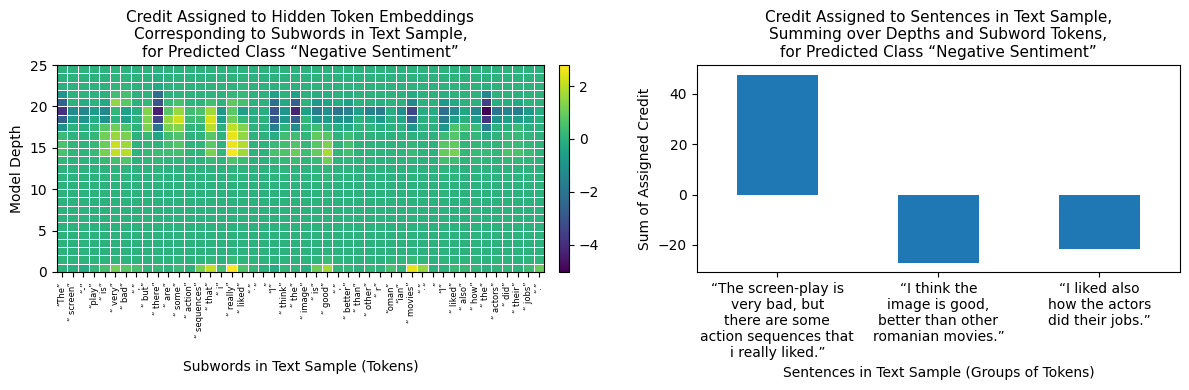

In [6]:
sample = splits['test'][2654]  # try a random sample from the test dataset
print('<Start of text>\n{}\n<End of text>\n'.format(sample['text']))
data = _get_credit_assignments_for_natural_language_sample(sample)

fig, axes = plt.subplots(ncols=2, figsize=(12, 4), width_ratios=[0.55, 0.45])

axis = axes[0]
_colorable = axis.pcolormesh(data['credit_to_hid_embs'].T, edgecolors='w', lw=0.5)
axis.set_xticks(np.arange(len(data['subwords'])) + 0.5)
axis.set_xticklabels(_quote_subwords(data['subwords']), rotation=90, fontsize=6)
axis.set_title("Credit Assigned to Hidden Token Embeddings\nCorresponding to Subwords in Text Sample,\nfor Predicted Class “{}”".format(['Negative Sentiment', 'Positive Sentiment'][data['pred_class']]),
              fontsize=11)
axis.set(xlabel='\nSubwords in Text Sample (Tokens)', ylabel='Model Depth')
_colorbar = fig.colorbar(_colorable, ax=axis, pad=0.025)

axis = axes[1]
series = pd.Series(index=_break_sents(data['sents'], 3), data=data['credit_to_sents'])
series.plot.bar(ax=axis, rot=0)
axis.set_title("Credit Assigned to Sentences in Text Sample,\nSumming over Depths and Subword Tokens,\nfor Predicted Class “{}”".format(['Negative Sentiment', 'Positive Sentiment'][data['pred_class']]),
              fontsize=11)
# axis.set_title("Relative Magnitude of Credit Assigned to Sentences in\nSample for Predicted Class {} (“{}”)".format(pred_class, ['Negative Sentiment', 'Positive Sentiment'][pred_class]))
axis.set(xlabel='Sentences in Text Sample (Groups of Tokens)', ylabel='Sum of Assigned Credit')
fig.tight_layout()

<Start of text>
Seeing this movie in previews I thought it would be witty and in good spirits. Unfortunately it was a standard case of "the funny bits were in the preview", not to say it was all bad. But "the good bits were in the preview".

If you are looking for an adolescent movie that will put you to sleep then Watch this movie.
<End of text>



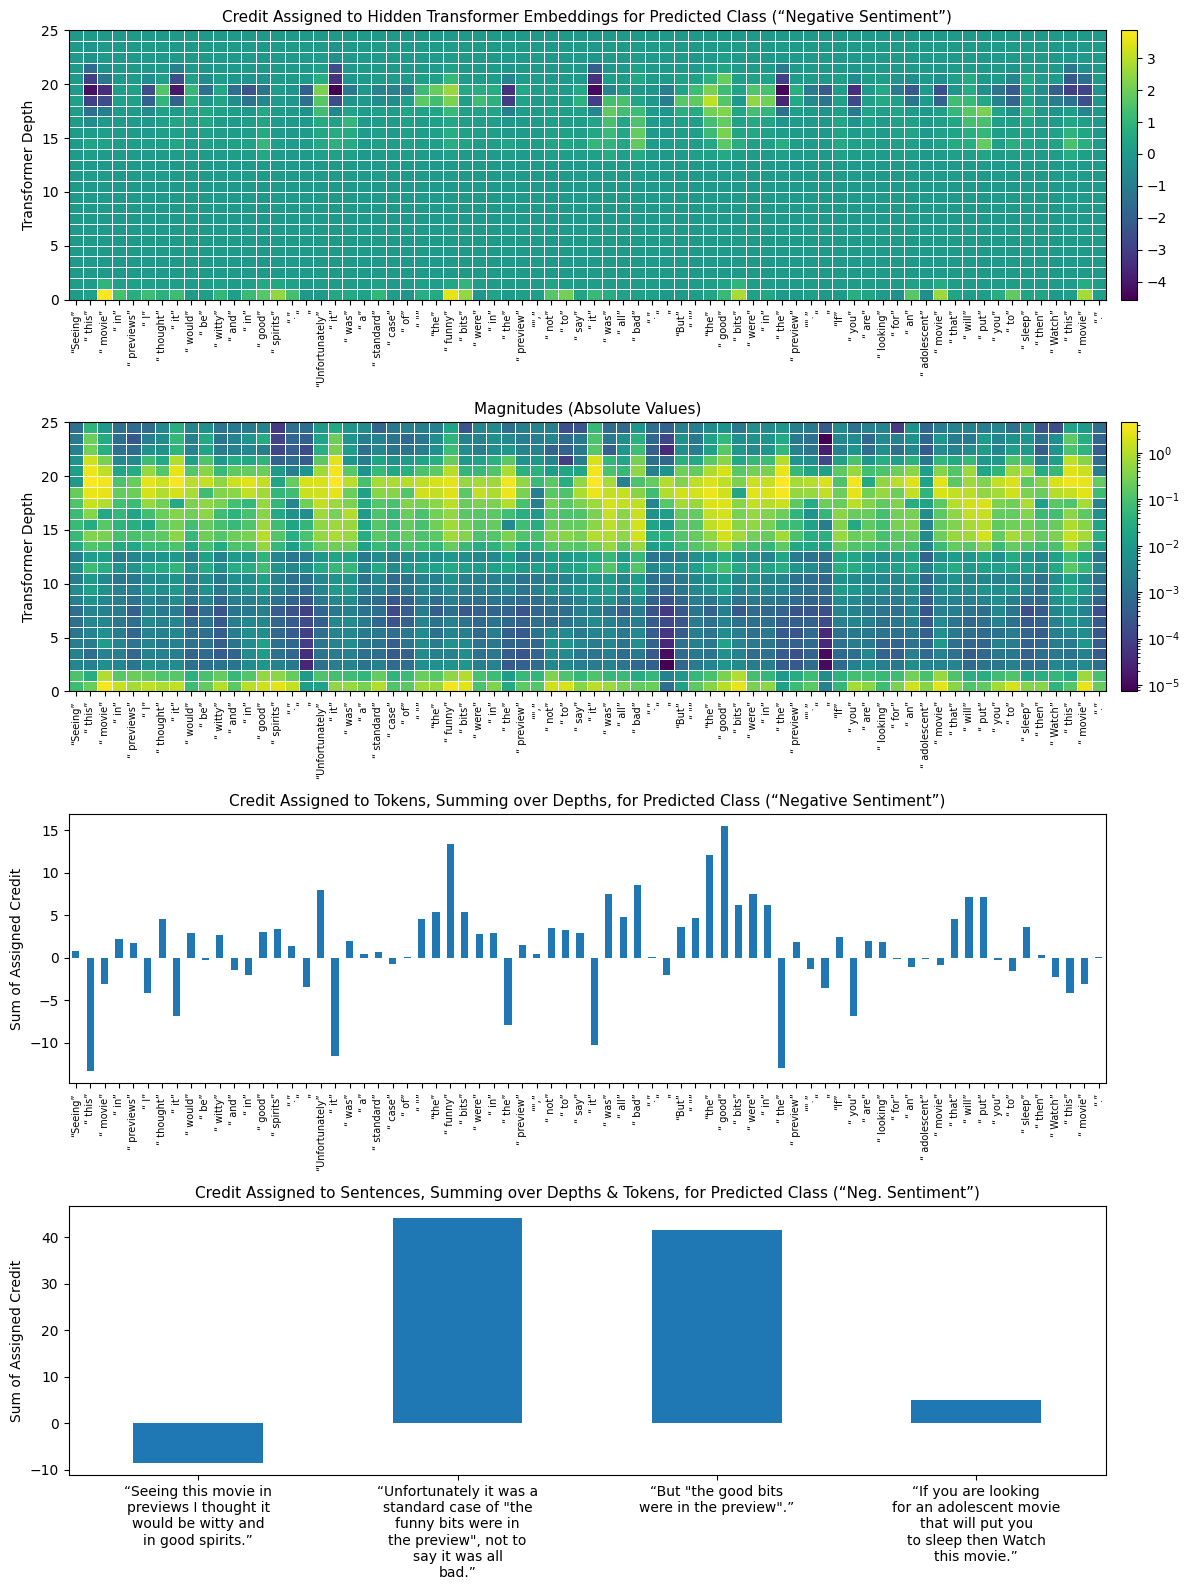

In [7]:
sample = splits['test'][3109]  # try a random sample from the test dataset
print('<Start of text>\n{}\n<End of text>\n'.format(sample['text']))
data = _get_credit_assignments_for_natural_language_sample(sample)

fig, axes = plt.subplots(nrows=4, ncols=2, width_ratios=[0.985, 0.015], figsize=(12, 16))

axis = axes[0, 0]
_colorable = axis.pcolormesh(data['credit_to_hid_embs'].T, edgecolors='w', lw=0.5)
axis.set_xticks(np.arange(len(data['subwords'])) + 0.5)
axis.set_xticklabels(_quote_subwords(data['subwords']), rotation=90, fontsize=7)
axis.set_title("Credit Assigned to Hidden Transformer Embeddings for Predicted Class (“{}”)".format(['Negative Sentiment', 'Positive Sentiment'][data['pred_class']]), fontsize=11)
axis.set(ylabel='Transformer Depth')
fig.colorbar(_colorable, ax=axis, cax=axes[0, 1])

axis = axes[1, 0]
_colorable = axis.pcolormesh(data['credit_to_hid_embs'].T.abs(), edgecolors='w', lw=0.5, norm='log')
axis.set_xticks(np.arange(len(data['subwords'])) + 0.5)
axis.set_xticklabels(_quote_subwords(data['subwords']), rotation=90, fontsize=7)
axis.set_title("Magnitudes (Absolute Values)", fontsize=11)
axis.set(ylabel='Transformer Depth')
fig.colorbar(_colorable, ax=axis, cax=axes[1, 1])

axis = axes[2, 0]
series = pd.Series(index=data['subwords'], data=data['credit_to_subwords'])
series.plot.bar(ax=axis)
axis.set_title("Credit Assigned to Tokens, Summing over Depths, for Predicted Class (“{}”)".format(['Negative Sentiment', 'Positive Sentiment'][data['pred_class']]), fontsize=11)
axis.set_xticklabels(_quote_subwords(data['subwords']), rotation=90, fontsize=7)
axis.set(ylabel='Sum of Assigned Credit')
axes[2, 1].axis('off')

axis = axes[3, 0]
series = pd.Series(index=_break_sents(data['sents'], 4), data=data['credit_to_sents'])
series.plot.bar(ax=axis, rot=0)
axis.set_title("Credit Assigned to Sentences, Summing over Depths & Tokens, for Predicted Class (“{}”)".format(['Neg. Sentiment', 'Pos. Sentiment'][data['pred_class']]), fontsize=11)
axis.set(ylabel='Sum of Assigned Credit')
axes[3, 1].axis('off')

fig.tight_layout()

In [8]:
# Clear credit assignments and remove forward hooks handles.
credit_assignments.clear()
credit_assignments.remove_hooks()